In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-minigrid-trans-ablation --history_vars n_step random_state_distrib_kl_div_mean goal_state_distrib_kl_div_mean explore_right_state_distrib_kl_div_mean --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim trans_hidden
# python download_data.py --project=discrete-mbrl-minigrid-trans-ablation --history_vars n_step random_state_distrib_kl_div goal_state_distrib_kl_div explore_right_state_distrib_kl_div --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim trans_hidden

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
data_path = 'data/discrete-mbrl-minigrid-trans-ablation_data.csv'
df = pd.read_csv(data_path, index_col=0)
df.head()

,step,n_step,ae_model_type,codebook_size,env_name,filter_size,latent_dim,trans_hidden,experiment_key,explore_right_state_distrib_kl_div_mean,goal_state_distrib_kl_div_mean
0,0,0,ae,None,minigrid-crossing-stochastic,8.0,256,32.0,b83179d46099490b9b54a02ac8506cd4,NaN,NaN
1,1,1,ae,None,minigrid-crossing-stochastic,8.0,256,32.0,b83179d46099490b9b54a02ac8506cd4,NaN,NaN
2,2,2,ae,None,minigrid-crossing-stochastic,8.0,256,32.0,b83179d46099490b9b54a02ac8506cd4,NaN,NaN
3,3,3,ae,None,minigrid-crossing-stochastic,8.0,256,32.0,b83179d46099490b9b54a02ac8506cd4,NaN,NaN
4,4,4,ae,None,minigrid-crossing-stochastic,8.0,256,32.0,b83179d46099490b9b54a02ac8506cd4,NaN,NaN


In [3]:
kl_div_columns = [col for col in df.columns if 'kl_div' in col]
# Drop the rows where all of the columns are NaN
df = df.dropna(subset=kl_div_columns, how='all')

In [4]:
# Work out the policy types and simplify the KL divergence columns

def infer_policy_type(row):
  for key, val in row.items():
    if 'kl_div' in key and val is not None and not np.isnan(val):
      return key[:key.find('state')-1]
    

df['policy_type'] = df.apply(infer_policy_type, axis=1)
# df['state_distrib_kl_div'] = df.apply(
#   lambda row: row[row['policy_type'] + '_state_distrib_kl_div'],
#   axis=1)
df['state_distrib_kl_div_mean'] = df.apply(
  lambda row: row[row['policy_type'] + '_state_distrib_kl_div_mean'],
  axis=1)

df.drop(columns=kl_div_columns, inplace=True)

In [5]:
df['latent_dim'] = df.apply(
  lambda row: f'({row["filter_size"]**2} x {row["codebook_size"]})' \
  if row['ae_model_type'] == 'vqvae' else row['latent_dim'], axis=1)

minigrid-crossing-stochastic | ae | explore_right

----- Trans Size: 16.0 -----

Latent dim: 1024, KL div mean: 4.322, n_runs: 4
Latent dim: 16, KL div mean: 5.592, n_runs: 6
Latent dim: 256, KL div mean: 3.790, n_runs: 6
Latent dim: 64, KL div mean: 4.867, n_runs: 5
Best params: 256 with KL div mean: 3.790
minigrid-crossing-stochastic | ae | explore_right

----- Trans Size: 32.0 -----

Latent dim: 1024, KL div mean: 1.871, n_runs: 4
Latent dim: 16, KL div mean: 3.466, n_runs: 5
Latent dim: 256, KL div mean: 2.347, n_runs: 4
Latent dim: 64, KL div mean: 2.848, n_runs: 6
Best params: 1024 with KL div mean: 1.871
minigrid-crossing-stochastic | ae | explore_right

----- Trans Size: 64.0 -----

Latent dim: 1024, KL div mean: 0.717, n_runs: 4
Latent dim: 16, KL div mean: 1.357, n_runs: 4
Latent dim: 256, KL div mean: 0.894, n_runs: 5
Latent dim: 64, KL div mean: 1.776, n_runs: 4
Best params: 1024 with KL div mean: 0.717
minigrid-crossing-stochastic | ae | explore_right

----- Trans Size: 12

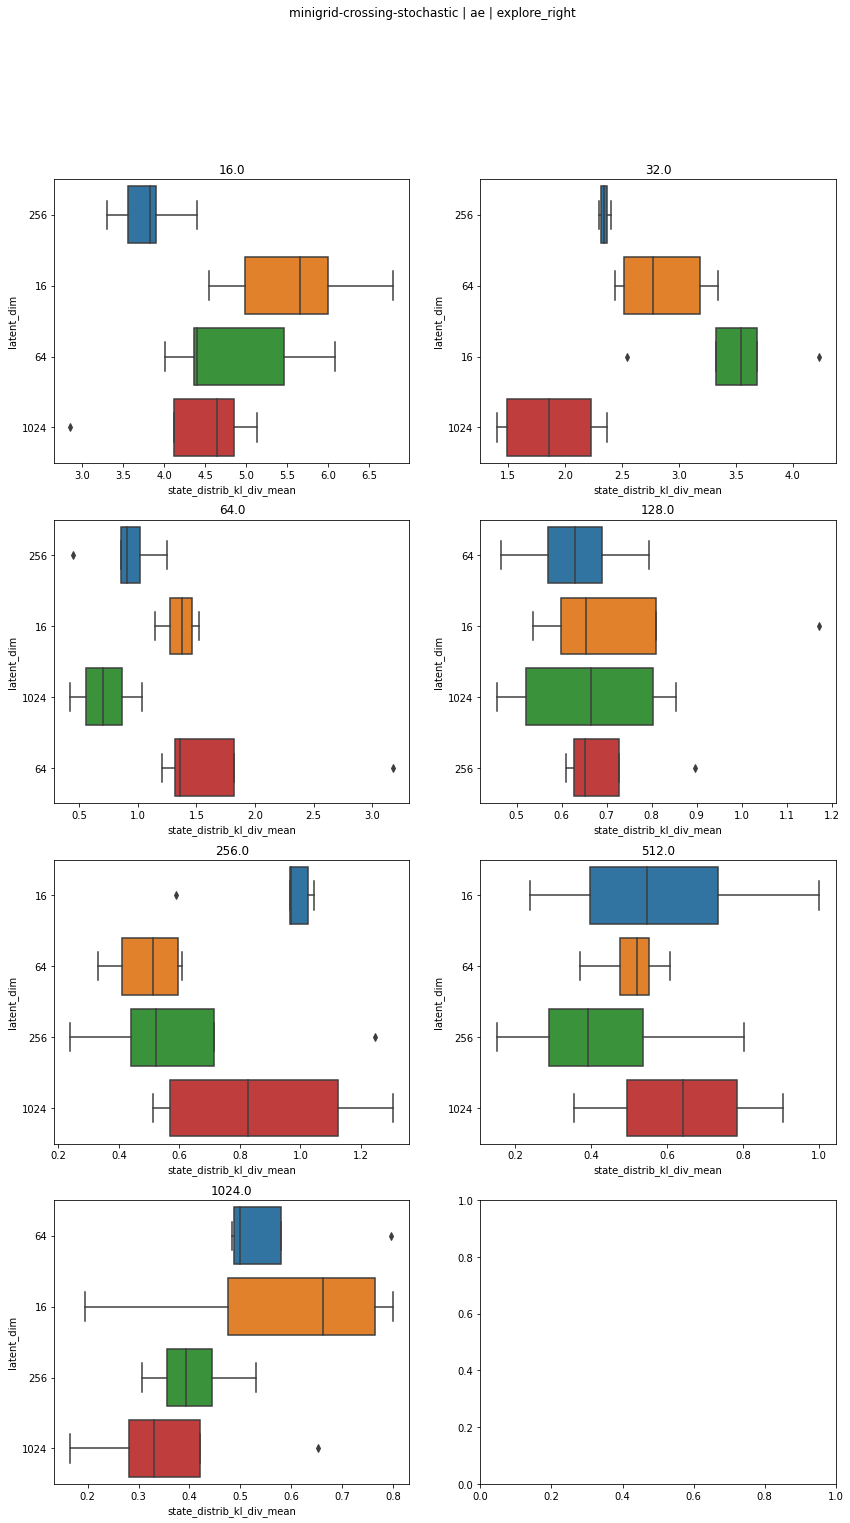

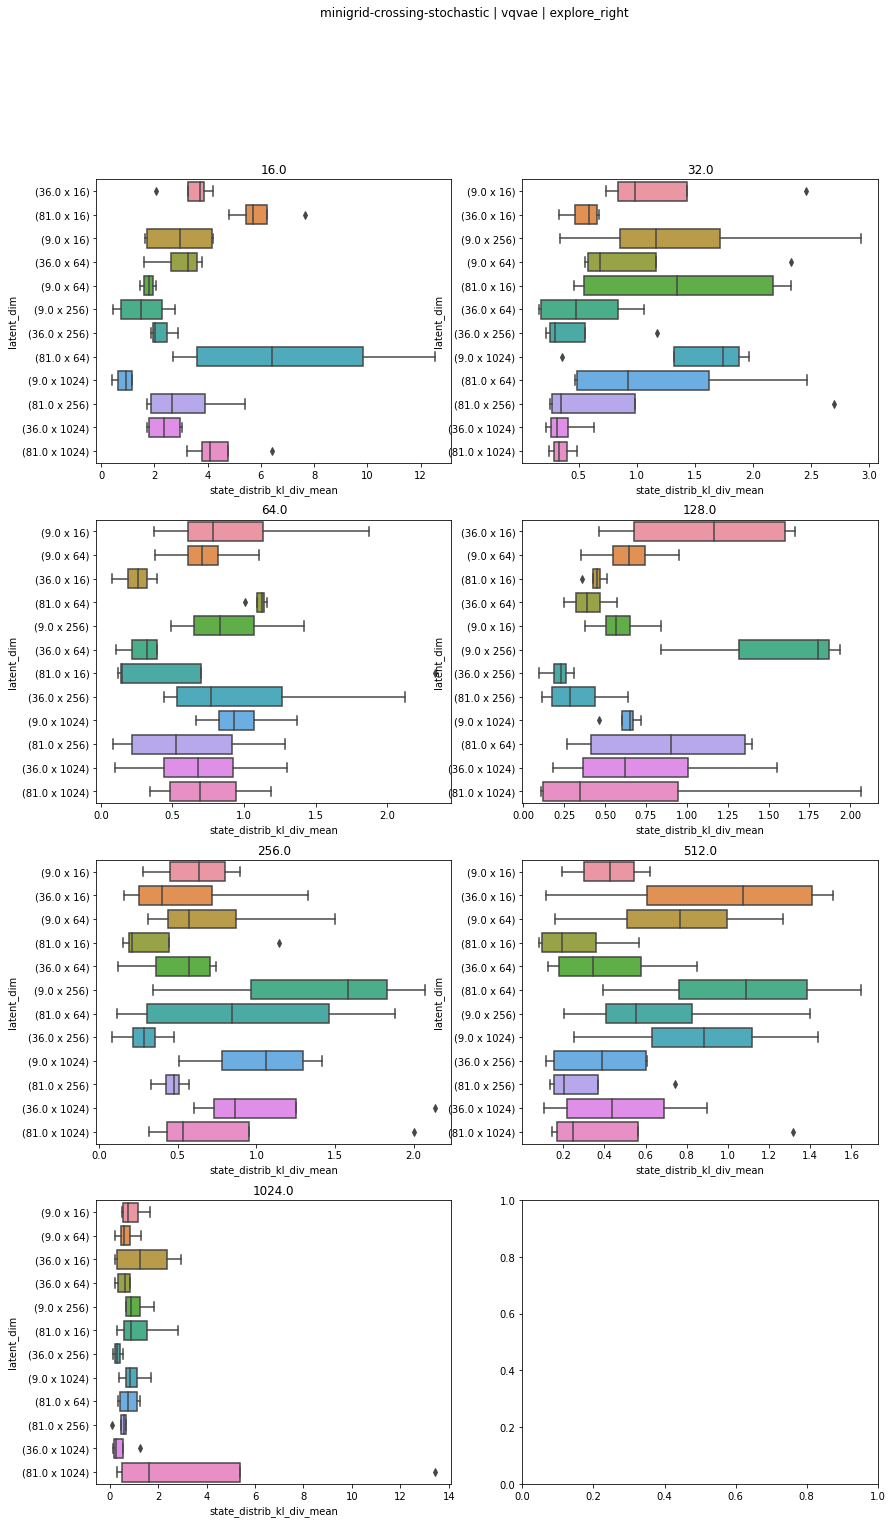

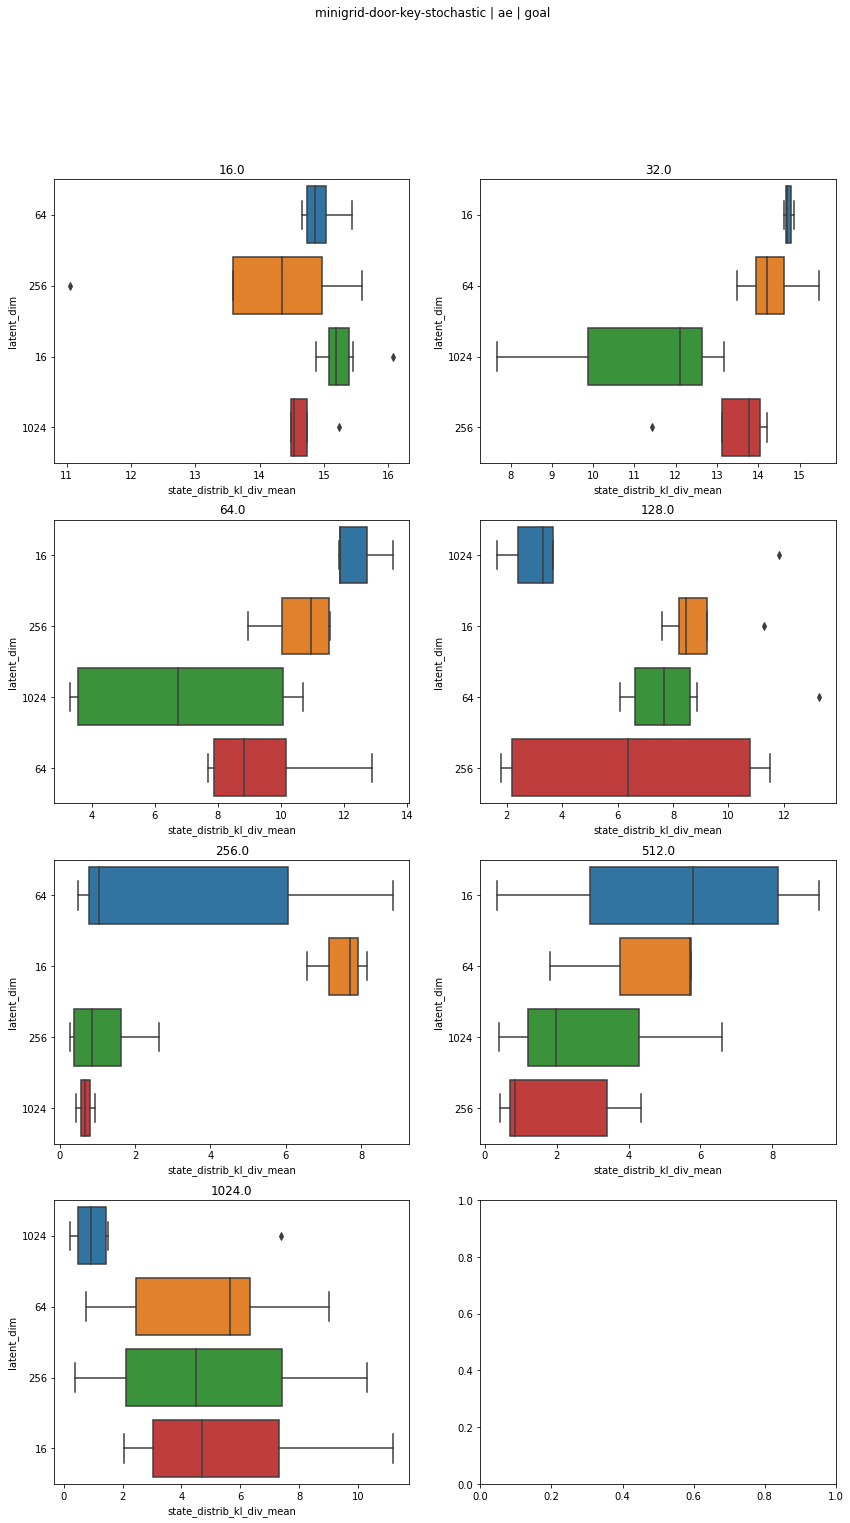

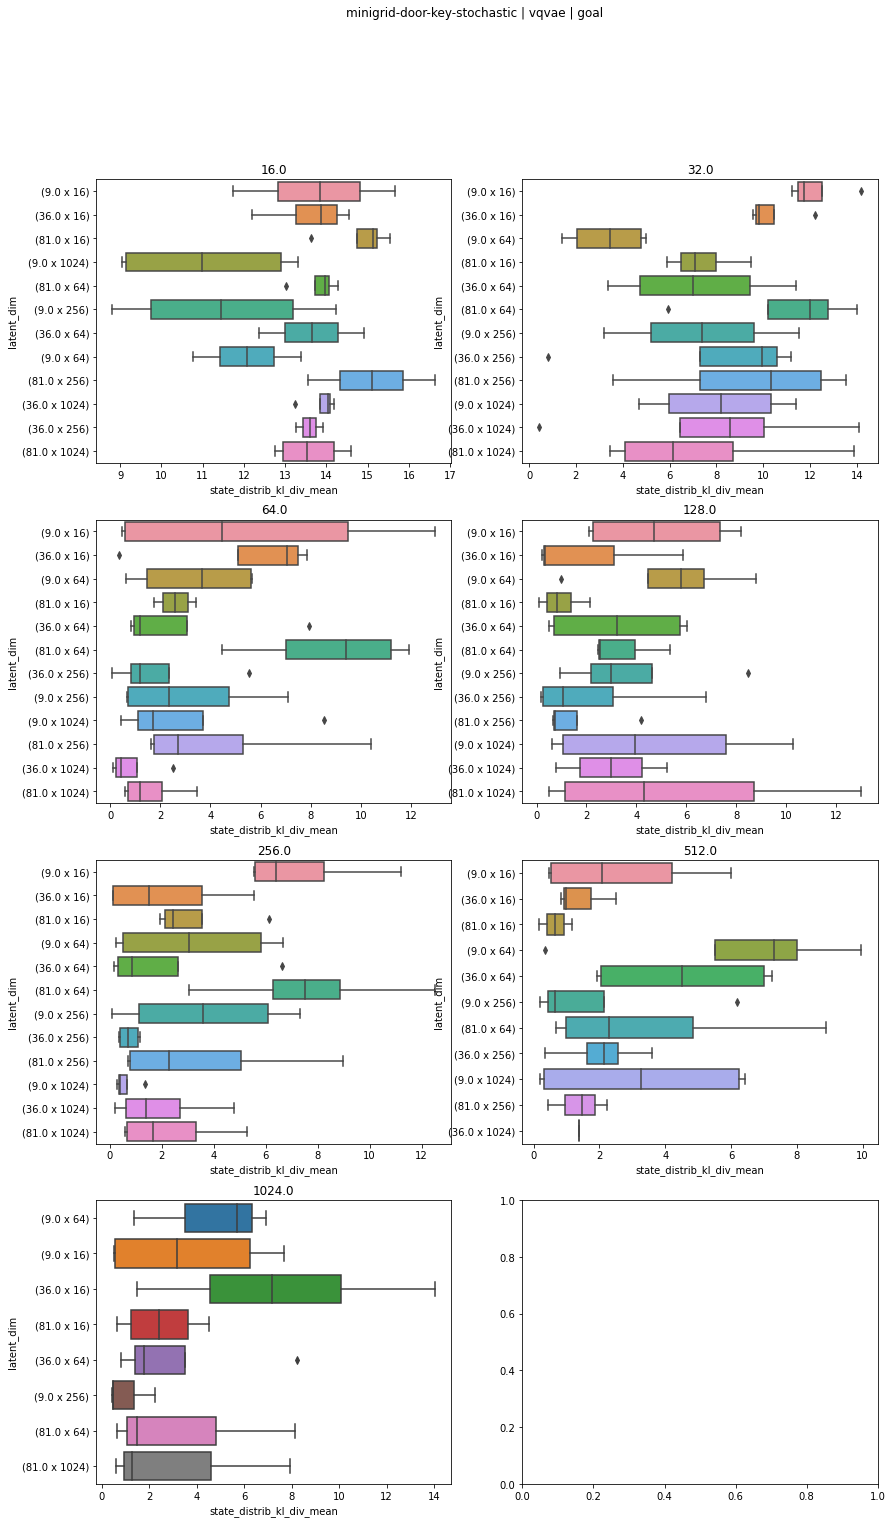

In [8]:
for keys, group in df.groupby(['env_name', 'ae_model_type', 'policy_type']):
  # Make a subplot for each value of trans_hidden
  fig, axs = plt.subplots(4, 2, figsize=(14, 24))
  fig.suptitle(' | '.join(keys))

  for i, (trans_size, trans_group) in enumerate(group.groupby('trans_hidden')):
    # Sort df first by filter size, then by codebook size
    ax = axs.flatten()[i]
    ax.set_title(trans_size)
    sns.boxplot(trans_group, x='state_distrib_kl_div_mean', y='latent_dim', ax=ax)

    # Avg of kl_div_mean for each latent dim and report lowest value + num of runs
    print(' | '.join(keys))
    lowest_kl_div_mean = np.inf
    best_latent_dim = None

    print(f'\n----- Trans Size: {trans_size} -----\n')
    for latent_dim, sub_group in trans_group.groupby('latent_dim'):
      kl_div_mean = sub_group['state_distrib_kl_div_mean'].mean()
      n_runs = len(sub_group)
      print(f'Latent dim: {latent_dim}, KL div mean: {kl_div_mean:.3f}, n_runs: {n_runs}')

      if kl_div_mean < lowest_kl_div_mean:
        lowest_kl_div_mean = kl_div_mean
        best_latent_dim = latent_dim
    # Report min with latent dim
    print(f'Best params: {best_latent_dim} with KL div mean: {lowest_kl_div_mean:.3f}')


  # # Sort df first by filter size, then by codebook size
  # group = group.sort_values(by=['filter_size', 'codebook_size'])
  # plt.figure(figsize=(14, 6))
  # plt.title(' | '.join(keys))
  # sns.boxplot(group, x='latent_dim', y='state_distrib_kl_div_mean')

  # # Avg of kl_div_mean for each latent dim and report lowest value + num of runs
  # print(' | '.join(keys))
  # lowest_kl_div_mean = np.inf
  # best_latent_dim = None
  # for latent_dim, group in group.groupby('latent_dim'):
  #   kl_div_mean = group['state_distrib_kl_div_mean'].mean()
  #   n_runs = len(group)
  #   print(f'Latent dim: {latent_dim}, KL div mean: {kl_div_mean:.3f}, n_runs: {n_runs}')

  #   if kl_div_mean < lowest_kl_div_mean:
  #     lowest_kl_div_mean = kl_div_mean
  #     best_latent_dim = latent_dim
  # # Report min with latent dim
  # print(f'Best params: {best_latent_dim} with KL div mean: {lowest_kl_div_mean:.3f}')